<a href="https://colab.research.google.com/github/brendadenisse16/Discrete-Optimization/blob/main/Model_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%pip install tensorflow

In [9]:
#Random Forest with basic sensors (not Heading) + Dist Metro and Bus Corridors & IsAndroid
"""
Created on Thu June 9 2022

@author: BC
"""


#%pip install tensorflow_decision_forests

import tensorflow_decision_forests as tfdf
import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit  # to do stratified sampling
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from scipy.stats import skew
from scipy.stats import kurtosis
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import os

import importlib


# upload raw data
df = pd.read_csv('new_20220428clean_copy.csv')

total = len(df)

# feature engineering with statistical features
dataList = df.values.tolist()

Number_variable = 11 # number of variables (without heading )
Number_rawsessions = 6 # number of snapshots for aggregation
Gap_between_snapshot = 120000 #nano_seconds

Datanew = []

count = 0
for i in range(len(dataList)):
    #print(i)
    # Pour changer le nombre de snapshot à considérer
    if (i>=5 and i!=(len(dataList)-1)):
        if (
           #6 first snapshot have the same TM
            dataList[i][4]==dataList[i-1][4] and dataList[i][4]==dataList[i-2][4] 
            and dataList[i][4]==dataList[i-3][4] and dataList[i][4]==dataList[i-4][4] 
            and dataList[i][4]==dataList[i-5][4]  

            #TM are only Car
            and dataList[i][4]!='walk' and dataList[i][4]!='run' and dataList[i][4]!='bike' 

            #All the same user
            and dataList[i][6]==dataList[i-1][6] and dataList[i][6]==dataList[i-2][6] 
            and dataList[i][6]==dataList[i-3][6] and dataList[i][6]==dataList[i-4][6] 
            and dataList[i][6]==dataList[i-5][6]

            #Maximum gap  between snapshot...
            and (dataList[i][5]-dataList[i-1][5])<Gap_between_snapshot and (dataList[i-1][5]-dataList[i-2][5])<Gap_between_snapshot 
            and (dataList[i-2][5]-dataList[i-3][5])<Gap_between_snapshot and (dataList[i-3][5]-dataList[i-4][5])<Gap_between_snapshot 
            and (dataList[i-4][5]-dataList[i-5][5])<Gap_between_snapshot

            ):
            #X=[count,dataList[i][13]]
            # [dataList[i][0]: PID
            # dataList[i][5]: Transport mode 
            X=[dataList[i][0], count, dataList[i][4]] #variables:PID, count y ActitivityType
            #print(dataList[i][5])
            #print(dataList[i-1][1])
            for j in range(Number_variable):
                if ((j+1) < 4): # con esto se que solo abarca :speed,  accuracy and altitde variables (col 1 a 3)
              #10 = distance -» Tout sauf distanceBus et Train apres mangent (6)
           #     if ((j+1) < 4 ):
                  data = [dataList[i-1][j+1],dataList[i][j+1],dataList[i-2][j+1],dataList[i-3][j+1],dataList[i-4][j+1],dataList[i-5][j+1]]  
                  x1 =  np.min(data)
                  x2 =  np.max(data)
                  x3 =  np.mean(data)
                  x4 =  np.std(data)
                  
                  #new features
                  x5 =  np.median(data)
                  x6 =  np.percentile((data),75)

                  X = X+[x1,x2,x3,x4,x5,x6]

                if ((j+1) >= 7 and (j+1) < 11): #con esto solo cubre las columnas: busDistanceStops, TrainDistance, BusCorridorDistance and MetroDistance
                  x1 = np.sum([dataList[i-1][j+1],dataList[i][j+1],dataList[i-2][j+1],dataList[i-3][j+1],dataList[i-4][j+1],dataList[i-5][j+1]])
                  X = X + [x1]
                if ((j+1) == 11 ): # se refiere a la variable "isAndroid"
                  x1 = dataList[i][j+1]
                  X = X + [x1]

            Datanew.append(X) 
            count = count + 1
            #print(X)
#random.shuffle(Datanew)

Features= pd.DataFrame(Datanew, columns = ['id', 'count', 'transportation_mode', 
                              'minSpeed' ,'maxSpeed', 'meanSpeed', 'stdSpeed','medianSpeed','75thPerSpeed',
                              'minAccuracy' ,'maxAccuracy', 'meanAccuracy', 'stdAccuracy', 'medianAccuracy','75thPerAccuracy',
                              'minAlt' ,'maxAlt', 'meanAlt', 'stdAlt', 'medianAlt','75thPerAlt',
                              'NumDist','NumDistTrain','NumDistBusCorridor','NumDistMetro','IsAndroid'
                              ])

# Process to  split data in stratified way
data = Features.iloc[0:,2:Features.shape[1]]
data['target_labeled'] = LabelEncoder().fit_transform(Features.iloc[0:,2])
data =data[['target_labeled','minSpeed' ,'maxSpeed', 'meanSpeed', 'stdSpeed','medianSpeed','75thPerSpeed',
                              'minAccuracy' ,'maxAccuracy', 'meanAccuracy', 'stdAccuracy', 'medianAccuracy','75thPerAccuracy',
                              'minAlt' ,'maxAlt', 'meanAlt', 'stdAlt', 'medianAlt','75thPerAlt',
                              'NumDist','NumDistTrain','NumDistBusCorridor','NumDistMetro','IsAndroid']] 

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.33, random_state=42)
for train_index, test_index in split.split(data, data['target_labeled']):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]


# Convert the pandas dataframe into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(strat_train, label="target_labeled")

# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(strat_test, label="target_labeled")

# Train the model using Random Forest
model = tfdf.keras.RandomForestModel(num_trees=69, max_depth=35, min_examples=4, random_seed=0)
#model = tfdf.keras.RandomForestModel(num_trees=69, min_examples=4, random_seed=0)
model.fit(train_ds)

#Evaluating the performance of the model
model.compile(metrics=["accuracy"])
print(model.evaluate(test_ds))

loss, test_acc = model.evaluate(test_ds, verbose=0)
#evalutat the train model
train_loss, train_acc = model.evaluate(train_ds, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# prediction with test data set
Y_predicted = model.predict(test_ds)

y_pred_bool = np.argmax(Y_predicted, axis=1)

y_testdf = strat_test.iloc[0:,0].to_numpy().astype('int32')

print("classification accuracy for each mode:")
print(classification_report(y_testdf, y_pred_bool))

print("confusion_matrix: ")
print(confusion_matrix(y_testdf, y_pred_bool))

print("ROC accuracy score:")
print(roc_auc_score(y_testdf, Y_predicted, multi_class='ovo'))



Use /tmp/tmp8wjkkv2a as temporary training directory
Reading training dataset...


/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


Training dataset read in 0:00:01.380379. Found 59401 examples.
Training model...
Model trained in 0:00:34.135589
Compiling model...
Model compiled.
30/30 [==============================] - 1s 32ms/step - loss: 0.0000e+00 - accuracy: 0.9600
[0.0, 0.9600109457969666]
Train: 0.997, Test: 0.960
30/30 [==============================] - 1s 34ms/step
classification accuracy for each mode:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80      3190
           1       0.96      0.99      0.98     23938
           2       0.97      0.97      0.97      1295
           3       0.99      0.99      0.99       835

    accuracy                           0.96     29258
   macro avg       0.97      0.91      0.93     29258
weighted avg       0.96      0.96      0.96     29258

confusion_matrix: 
[[ 2200   967    20     3]
 [  111 23809    12     6]
 [    8    37  1250     0]
 [    0     3     3   829]]
ROC accuracy score:
0.9965141540965137


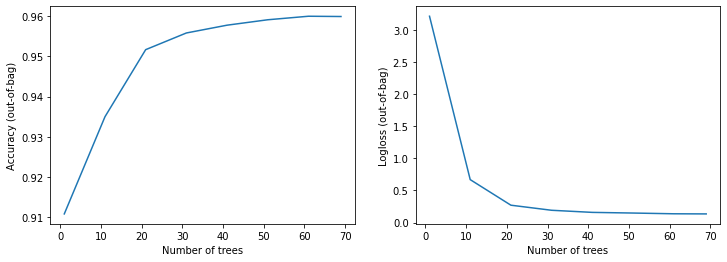

In [10]:
#Plotting the training logs
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()


In [11]:
# The feature importances
#model.make_inspector().variable_importances()

inspector = model.make_inspector()


In [12]:
#Best Features
print("Input features:", inspector.features())


Input features: ["75thPerAccuracy" (1; #0), "75thPerAlt" (1; #1), "75thPerSpeed" (1; #2), "IsAndroid" (1; #3), "NumDist" (1; #4), "NumDistBusCorridor" (1; #5), "NumDistMetro" (1; #6), "NumDistTrain" (1; #7), "maxAccuracy" (1; #8), "maxAlt" (1; #9), "maxSpeed" (1; #10), "meanAccuracy" (1; #11), "meanAlt" (1; #12), "meanSpeed" (1; #13), "medianAccuracy" (1; #14), "medianAlt" (1; #15), "medianSpeed" (1; #16), "minAccuracy" (1; #17), "minAlt" (1; #18), "minSpeed" (1; #19), "stdAccuracy" (1; #20), "stdAlt" (1; #21), "stdSpeed" (1; #22)]


In [13]:
#model.make_inspector().variable_importances()
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)


Available variable importances:
	 NUM_NODES
	 NUM_AS_ROOT
	 SUM_SCORE
	 MEAN_MIN_DEPTH


In [14]:
# Mean decrease in AUC of the class 1 vs the others.
inspector.variable_importances()["NUM_AS_ROOT"]


[("75thPerSpeed" (1; #2), 18.0),
 ("maxSpeed" (1; #10), 14.0),
 ("medianSpeed" (1; #16), 12.0),
 ("meanSpeed" (1; #13), 9.0),
 ("NumDistTrain" (1; #7), 6.0),
 ("75thPerAccuracy" (1; #0), 2.0),
 ("maxAccuracy" (1; #8), 2.0),
 ("medianAccuracy" (1; #14), 2.0),
 ("minAccuracy" (1; #17), 2.0),
 ("meanAccuracy" (1; #11), 1.0),
 ("stdAccuracy" (1; #20), 1.0)]

Saved Model

In [15]:
# Export the model to a TensorFlow SavedModel
model.save("project/model_randomforest")

INFO:tensorflow:Assets written to: project/model_randomforest/assets


INFO:tensorflow:Assets written to: project/model_randomforest/assets


In [ ]:
#from tensorflow.keras.models import load_model

# load  model
load_model = tf.keras.models.load_model('project/model_randomforest')

# Convert the model tf.lite
converter = tf.lite.TFLiteConverter.from_keras_model(load_model)
#converter.experimental_new_converter = True
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpauusj6s3/assets


INFO:tensorflow:Assets written to: /tmp/tmpauusj6s3/assets


ConverterError: ignored

In [ ]:
# Check its architecture
load_model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________


In [ ]:
# Evaluate the restored model
loss, acc = load_model.evaluate(test_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))


30/30 - 1s - loss: 0.0000e+00 - accuracy: 0.9600 - 986ms/epoch - 33ms/step
Restored model, accuracy: 96.00%


In [ ]:
#  TEST for Algorithm with new Data

#Random Forest with basic sensors (not Heading) + Dist Metro and Bus Corridors & IsAndroid
"""
Created on Thu June 9 2022

@author: BC
"""


#%pip install tensorflow_decision_forests

import tensorflow_decision_forests as tfdf
import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit  # to do stratified sampling
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from scipy.stats import skew
from scipy.stats import kurtosis
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import os

import importlib


# upload raw data
df = pd.read_csv('new_test_20.csv')

total = len(df)

# feature engineering with statistical features
dataList = df.values.tolist()

Number_variable = 11 # number of variables (without heading )
Number_rawsessions = 6 # number of snapshots for aggregation
Gap_between_snapshot = 120000 #nano_seconds

Datanew = []

count = 0
for i in range(len(dataList)):
    #print(i)
    # Pour changer le nombre de snapshot à considérer
    if (i>=5 and i!=(len(dataList)-1)):
        if (
           #6 first snapshot have the same TM
            dataList[i][4]==dataList[i-1][4] and dataList[i][4]==dataList[i-2][4] 
            and dataList[i][4]==dataList[i-3][4] and dataList[i][4]==dataList[i-4][4] 
            and dataList[i][4]==dataList[i-5][4]  

            #TM are only Car
            and dataList[i][4]!='walk' and dataList[i][4]!='run' and dataList[i][4]!='bike' 

            #All the same user
            and dataList[i][6]==dataList[i-1][6] and dataList[i][6]==dataList[i-2][6] 
            and dataList[i][6]==dataList[i-3][6] and dataList[i][6]==dataList[i-4][6] 
            and dataList[i][6]==dataList[i-5][6]

            #Maximum gap  between snapshot...
            and (dataList[i][5]-dataList[i-1][5])<Gap_between_snapshot and (dataList[i-1][5]-dataList[i-2][5])<Gap_between_snapshot 
            and (dataList[i-2][5]-dataList[i-3][5])<Gap_between_snapshot and (dataList[i-3][5]-dataList[i-4][5])<Gap_between_snapshot 
            and (dataList[i-4][5]-dataList[i-5][5])<Gap_between_snapshot

            ):
            #X=[count,dataList[i][13]]
            # [dataList[i][0]: PID
            # dataList[i][5]: Transport mode 
            X=[dataList[i][0], count, dataList[i][4]] #variables:PID, count y ActitivityType
            #print(dataList[i][5])
            #print(dataList[i-1][1])
            for j in range(Number_variable):
                if ((j+1) < 4): # con esto se que solo abarca :speed,  accuracy and altitde variables (col 1 a 3)
              #10 = distance -» Tout sauf distanceBus et Train apres mangent (6)
           #     if ((j+1) < 4 ):
                  data = [dataList[i-1][j+1],dataList[i][j+1],dataList[i-2][j+1],dataList[i-3][j+1],dataList[i-4][j+1],dataList[i-5][j+1]]  
                  x1 =  np.min(data)
                  x2 =  np.max(data)
                  x3 =  np.mean(data)
                  x4 =  np.std(data)
                  
                  #new features
                  x5 =  np.median(data)
                  x6 =  np.percentile((data),75)

                  X = X+[x1,x2,x3,x4,x5,x6]

                if ((j+1) >= 7 and (j+1) < 11): #con esto solo cubre las columnas: busDistanceStops, TrainDistance, BusCorridorDistance and MetroDistance
                  x1 = np.sum([dataList[i-1][j+1],dataList[i][j+1],dataList[i-2][j+1],dataList[i-3][j+1],dataList[i-4][j+1],dataList[i-5][j+1]])
                  X = X + [x1]
                if ((j+1) == 11 ): # se refiere a la variable "isAndroid"
                  x1 = dataList[i][j+1]
                  X = X + [x1]

            Datanew.append(X) 
            count = count + 1
            #print(X)
#random.shuffle(Datanew)

Features= pd.DataFrame(Datanew, columns = ['id', 'count', 'transportation_mode', 
                              'minSpeed' ,'maxSpeed', 'meanSpeed', 'stdSpeed','medianSpeed','75thPerSpeed',
                              'minAccuracy' ,'maxAccuracy', 'meanAccuracy', 'stdAccuracy', 'medianAccuracy','75thPerAccuracy',
                              'minAlt' ,'maxAlt', 'meanAlt', 'stdAlt', 'medianAlt','75thPerAlt',
                              'NumDist','NumDistTrain','NumDistBusCorridor','NumDistMetro','IsAndroid'
                              ])


# Process to  split data in stratified way
data = Features.iloc[0:,2:Features.shape[1]]
data['target_labeled'] = LabelEncoder().fit_transform(Features.iloc[0:,2])
data =data[['target_labeled','minSpeed' ,'maxSpeed', 'meanSpeed', 'stdSpeed','medianSpeed','75thPerSpeed',
                              'minAccuracy' ,'maxAccuracy', 'meanAccuracy', 'stdAccuracy', 'medianAccuracy','75thPerAccuracy',
                              'minAlt' ,'maxAlt', 'meanAlt', 'stdAlt', 'medianAlt','75thPerAlt',
                              'NumDist','NumDistTrain','NumDistBusCorridor','NumDistMetro','IsAndroid']] 

# Convert the pandas dataframe into a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(data, label="target_labeled")

# my_model directory
load_model = tf.keras.models.load_model('project/model_randomforest')


#predictions = load_model.predict(test_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2542: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)
